![Fixel Algorithms](https://fixelalgorithms.co/images/CCExt.png)

# <center> Deep Learning Methods </center>
## <center> Lecture 11 - RNN </center>
### <center> Sentiment Analysis </center>

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/FixelAlgorithmsTeam/FixelCourses/blob/master/DeepLearningMethods/11_RNN/MainSentimentAnalysis.ipynb)

In [1]:
#-- Wide screen:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

In [2]:
#-- Auto reload:
%load_ext autoreload
%autoreload 2

In [3]:
import numpy             as np
import matplotlib.pyplot as plt

import torch
import torch.nn    as nn
import torch.optim as optim
import torchsummary
import torchtext

from torchtext.data.utils import get_tokenizer
from torchtext.vocab      import Vocab
from torchtext.datasets   import IMDB

In [4]:
if 'google.colab' in str(get_ipython()):
    !npx degit FixelAlgorithmsTeam/FixelCourses/DeepLearningMethods/11_RNN/DeepLearningFramework ./DeepLearningFramework

### Embedding layer:
Replace the integers $\left\{ 0,1,\dots,9\right\} $ by vectors in $\mathbb{R}^{5}$

In [5]:
oEmbedding = nn.Embedding(10, 5)
v          = torch.tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
oEmbedding(v)

tensor([[ 7.7482e-01,  1.1967e+00,  2.1194e-03, -6.1813e-01, -1.0037e+00],
        [ 1.8807e-01,  3.6197e-01, -2.5738e-01, -1.6832e+00,  6.0879e-01],
        [ 9.2038e-02, -7.1206e-01, -9.3759e-01,  6.0630e-01, -1.1850e+00],
        [ 1.4756e+00, -1.3298e+00,  8.8346e-01, -1.2152e+00, -2.4307e+00],
        [ 1.5091e+00, -8.5223e-01,  1.6969e+00, -8.1846e-01,  5.6317e-02],
        [ 8.3188e-01,  4.0002e-01,  3.6570e-01, -2.6178e-01, -1.7795e+00],
        [-4.0384e-01,  6.0951e-01, -1.8145e+00,  5.2584e-01, -5.8213e-01],
        [ 1.9168e+00, -6.8769e-01, -9.5595e-01,  1.0065e+00,  7.4277e-02],
        [ 1.1182e+00, -2.1325e+00,  3.7426e-01,  6.2051e-01,  1.1487e+00],
        [ 4.6182e-01,  3.3261e-01,  2.1073e+00, -8.9795e-01,  8.7363e-01]],
       grad_fn=<EmbeddingBackward>)

### Get the IMDB dataset:

In [6]:
dirPath             = '../../data'
oTokenizer          = get_tokenizer('basic_english')

trainIter, testIter = IMDB(root=dirPath)

lFullTrainSet = list(trainIter)
lFullTestSet  = list(testIter)

#### Filter long sequences:
Keep only sequences with less than `maxLength` words

In [7]:
def NumWords(line):
    return len(line.split())

maxLength = 100
lTrainSet = [(label, line) for (label, line) in lFullTrainSet if NumWords(line) < maxLength]
lTestSet  = [(label, line) for (label, line) in lFullTestSet  if NumWords(line) < maxLength]

In [8]:
len(lFullTrainSet), len(lFullTestSet), len(lTrainSet), len(lTestSet)

(25000, 25000, 2926, 3091)

#### Show some sentences:

In [9]:
import random

red   = '\x1b[31m'
green = '\x1b[32m'
end   = '\x1b[0m'

for _  in range(3):
    (label, line) = random.choice(lTrainSet)
    
    color = red if label == 'neg' else green
    print('=========================================================================================================')
    print('=========================================================================================================')
    print(color + line + end)
    print('--Tokenizer:---------------------------')    
    print(oTokenizer(line))

Excellent film from Thaddeus O'Sullivan featuring strong performances from a host of British and Irish actors. The film deals well with a thorny subject matter, and effectively captures the hopelessness and grim atmosphere of 1970s Belfast. Surprisingly realistic, it does nothing to glorify either side in this conflict. On one hand, it shows a young Catholic father trying to raise his family without getting drawn into the troubles. On the other it deals with a Loyalist gang who are intent on propagating violence. Very interesting and, thankfully, entertaining. Don't be expecting any laughs, though. 7 out of 10.
--Tokenizer:---------------------------
['excellent', 'film', 'from', 'thaddeus', 'o', "'", 'sullivan', 'featuring', 'strong', 'performances', 'from', 'a', 'host', 'of', 'british', 'and', 'irish', 'actors', '.', 'the', 'film', 'deals', 'well', 'with', 'a', 'thorny', 'subject', 'matter', ',', 'and', 'effectively', 'captures', 'the', 'hopelessness', 'and', 'grim', 'atmosphere', 'o

### Build the vocabulary:
We keep only words that appear more than `min_freq` times.

In [10]:
from torchtext.vocab import build_vocab_from_iterator

def YieldTokens(lDataset):
    for (label, line) in lDataset:
        yield oTokenizer(line)

oVocab = build_vocab_from_iterator(YieldTokens(lTrainSet), min_freq=5, specials=('<UNK>', '<SOS>', '<EOS>', '<PAD>'))
oVocab.set_default_index(oVocab['<UNK>'])
len(oVocab)

3268

#### Using the vocabulary:

In [11]:
oVocab['the'], oVocab['a'], oVocab['asfdlkasdjf'], oVocab['aaab'], oVocab['!']

(5, 7, 0, 0, 19)

In [12]:
oVocab.get_itos()[4], oVocab.get_itos()[8], oVocab.get_itos()[0], oVocab.get_itos()[19]

('.', 'and', '<UNK>', '!')

#### Text to sequence:

In [13]:
def Text2Tensor(line):
    return torch.tensor([oVocab['<BOS>']] + [oVocab[token] for token in oTokenizer(line)] + [oVocab['<EOS>']])

def Label2Int(label):
    if label == 'pos':
        return 1
    else:
        return 0

# Print out the output of text_transform
line = 'Hello World!'
print('Input :', line)
print('Output:', Text2Tensor(line))

Input : Hello World!
Output: tensor([   0, 3005,  196,   19,    2])


In [14]:
from torch.utils.data   import DataLoader
from torch.nn.utils.rnn import pack_sequence

def CollateBatch(lBatch):
    Nb  = len(lBatch)
    vY  = torch.empty(Nb)
    lX  = [None] * Nb
    for ii, (label, line) in enumerate(lBatch):
        vY[ii] = Label2Int  (label)
        lX[ii] = Text2Tensor(line)
    
    mPackX = pack_sequence(lX, enforce_sorted=False)

    return mPackX, vY

#### Remark
It is better to group lines with similar length together (as in `BucketIterator`).

In [15]:
batchSize = 64
oTrainDL  = DataLoader(lTrainSet, batch_size=batchSize,   shuffle=True,  collate_fn=CollateBatch)
oTestDL   = DataLoader(lTestSet,  batch_size=2*batchSize, shuffle=False, collate_fn=CollateBatch)

#### Define the RNN model:

In [16]:
from torch.nn.utils.rnn import PackedSequence

def PackedAs(mX, mPack):
    return PackedSequence(mX, mPack.batch_sizes, mPack.sorted_indices, mPack.unsorted_indices)

V = len(oVocab) #-- Vocab size
D = 64          #-- embedding dim
H = 256         #-- RNN hidden dim
class RNN(nn.Module):
    def __init__(self):
        super(RNN, self).__init__()
        
        self.oEmbedding = nn.Embedding(V, D)
        self.oRNN       = nn.RNN      (D, H, batch_first=True)
        self.oFC        = nn.Linear   (H, 1)
        
    def forward(self, mPackX):
                                              #-- mPackX.shape = (N*T,)
        mE     = self.oEmbedding(mPackX.data) #-- mE    .shape = (N*T, D)
        mPackE = PackedAs       (mE, mPackX)  #-- mPackE.shape = (N*T, D)
        _, mH = self.oRNN       (mPackE)      #-- mH    .shape = (1, N, H)
        mZ    = self.oFC        (mH[0])       #-- mZ    .shape = (N, 1)
        return mZ[:,0]

mPackX, vY = next(iter(oTrainDL))
RNN()(mPackX).shape

torch.Size([64])

In [17]:
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") 
Loss   = nn.BCEWithLogitsLoss()

In [18]:
from torch.optim.lr_scheduler       import OneCycleLR
from DeepLearningFramework.Metric   import BinaryAcuuracy
from DeepLearningFramework.Training import TrainModel

nEpochs    = 100
nIter      = nEpochs * len(oTrainDL)

oModel     = RNN       ().to(DEVICE)
oOptim     = optim.Adam(oModel.parameters(), lr=5e-6, betas=(0.8, 0.9))
oScheduler = OneCycleLR(oOptim, max_lr=5e-5, total_steps=nIter)
lHistory   = TrainModel(oModel, oTrainDL, oTestDL, Loss, BinaryAcuuracy, nEpochs, oOptim, oScheduler)

------------------------------------------------------------------------------------------------------------------------
Epoch 000: | Train loss:  0.690 | Val loss:  0.691 | Train Metric:  0.543 | Val Metric:  0.530 | epoch time:  1.525 | <-- Checkpoint!
Epoch 001: | Train loss:  0.689 | Val loss:  0.691 | Train Metric:  0.549 | Val Metric:  0.544 | epoch time:  0.950 | <-- Checkpoint!
Epoch 002: | Train loss:  0.688 | Val loss:  0.690 | Train Metric:  0.550 | Val Metric:  0.542 | epoch time:  0.945 |
Epoch 003: | Train loss:  0.687 | Val loss:  0.689 | Train Metric:  0.551 | Val Metric:  0.542 | epoch time:  0.956 |
Epoch 004: | Train loss:  0.686 | Val loss:  0.689 | Train Metric:  0.550 | Val Metric:  0.542 | epoch time:  0.919 |
Epoch 005: | Train loss:  0.685 | Val loss:  0.688 | Train Metric:  0.550 | Val Metric:  0.542 | epoch time:  0.913 |
Epoch 006: | Train loss:  0.684 | Val loss:  0.687 | Train Metric:  0.551 | Val Metric:  0.542 | epoch time:  0.928 |
Epoch 007: | Train lo

------------------------------------------------------------------------------------------------------------------------
Epoch 060: | Train loss:  0.466 | Val loss:  0.604 | Train Metric:  0.791 | Val Metric:  0.691 | epoch time:  0.938 |
Epoch 061: | Train loss:  0.463 | Val loss:  0.607 | Train Metric:  0.789 | Val Metric:  0.689 | epoch time:  0.942 |
Epoch 062: | Train loss:  0.459 | Val loss:  0.609 | Train Metric:  0.789 | Val Metric:  0.693 | epoch time:  0.930 | <-- Checkpoint!
Epoch 063: | Train loss:  0.456 | Val loss:  0.604 | Train Metric:  0.796 | Val Metric:  0.693 | epoch time:  0.918 |
Epoch 064: | Train loss:  0.454 | Val loss:  0.613 | Train Metric:  0.795 | Val Metric:  0.695 | epoch time:  0.925 | <-- Checkpoint!
Epoch 065: | Train loss:  0.453 | Val loss:  0.607 | Train Metric:  0.798 | Val Metric:  0.694 | epoch time:  0.937 |
Epoch 066: | Train loss:  0.451 | Val loss:  0.606 | Train Metric:  0.803 | Val Metric:  0.693 | epoch time:  0.917 |
Epoch 067: | Train lo

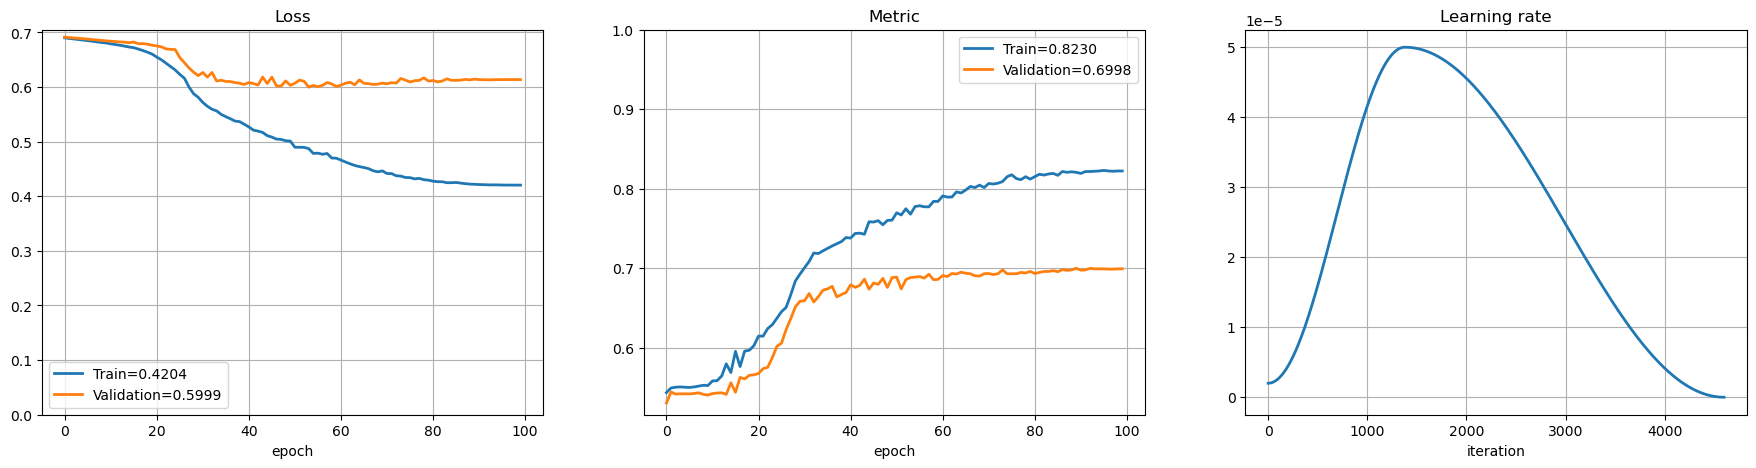

In [19]:
from DeepLearningFramework.Auxiliary import PlotHistory

PlotHistory(lHistory)
plt.show   ()